In [73]:
#  Load the "autoreload" extension so that code can change
%load_ext autoreload
%reload_ext autoreload
from pathlib import Path

#  always reload modules so that as you change code in src, it gets loaded
%autoreload 2
%matplotlib inline

import sys
sys.path.append('../')
from src.imports import *
from src.data.download_data import *
from src.data.fire_data import *
from src.data.read_data import *
from src.gen_functions import *
from src.features.dataset import Dataset
from src.features.build_features import *
from src.models.train_model import *
import seaborn as sns
output_notebook()
# set font size 
from src.visualization.vis_data import *
from src.visualization.vis_model import *
from src.models.train_model import *
from src.models.predict_model import *
plt.rcParams.update({'font.size': 16})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Loading BokehJS ...

# Model Performance

In [3]:
data, model, fire_cols, feat_imp = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7, 0.3])

rolling True
data no fire has shape (77747, 14)
model performance {'test_r2_score': 0.7087790905988873, 'test_mean_squared_error': 227.67283457136557, 'test_mean_absolute_error': 9.23587087862017}


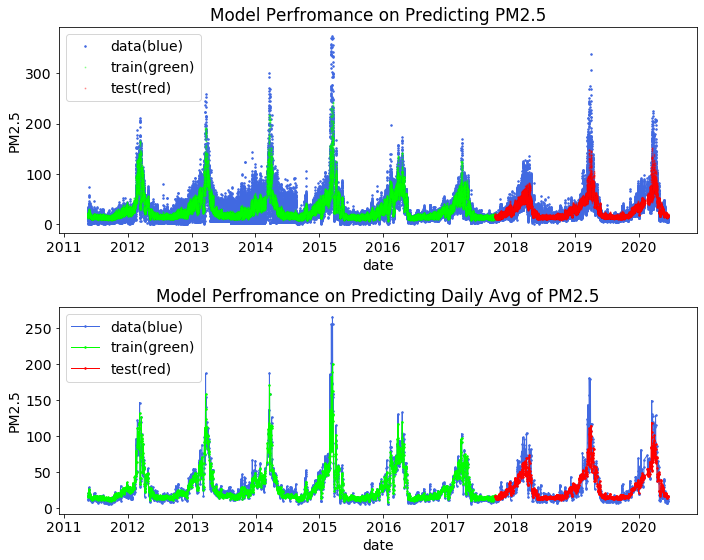

In [233]:
ytrn_pred_df, ytest_pred_df = plot_model_perf(dataset=data, model=model, split_list=[0.7, 0.3], xlim=[], to_save=True)

In [346]:
# calculate the average error
trn_error = cal_error(data, model, data_index=data.split_list[0])

# resample
ytrn_pred_df_avg = trn_error.resample('d').mean().dropna()
cal_scores(ytrn_pred_df_avg['actual'].values, ytrn_pred_df_avg['pred'].values, header_str='avg_trn_')

{'avg_trn_r2_score': 0.9450132986667232,
 'avg_trn_mean_squared_error': 35.925725806931965,
 'avg_trn_mean_absolute_error': 3.7745352329778226}

In [347]:
# calculate the average error
ytest_pred_df = cal_error(data, model, data_index=data.split_list[1])

# resample
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()
cal_scores(ytest_pred_df_avg['actual'].values, ytest_pred_df_avg['pred'].values, header_str='avg_test_')

{'avg_test_r2_score': 0.7828068417310021,
 'avg_test_mean_squared_error': 145.74247345984156,
 'avg_test_mean_absolute_error': 7.717591182233365}

## Average Error

Text(0.5, 1.0, 'error (by pollution season)')

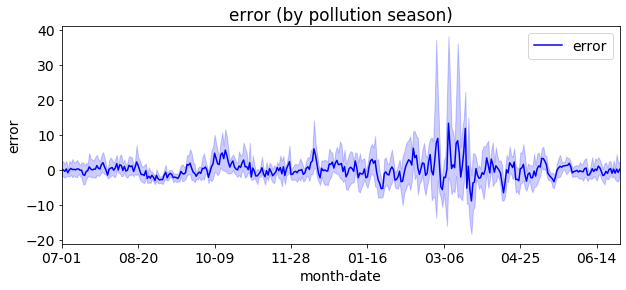

In [348]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'error', ax, plot_error=True, roll=False, agg='mean')
ax.set_title('error (by pollution season)')

Text(0.5, 1.0, 'rmse (by pollution season)')

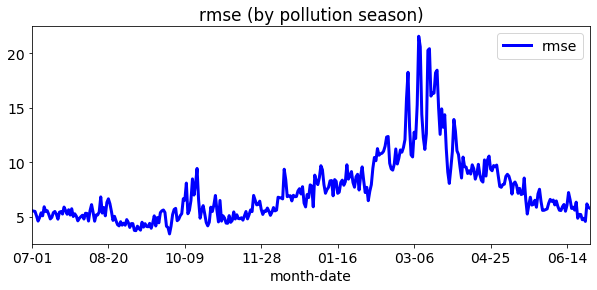

In [349]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'rmse', ax, plot_error=False, roll=True, agg='mean')
ax.set_title('rmse (by pollution season)')

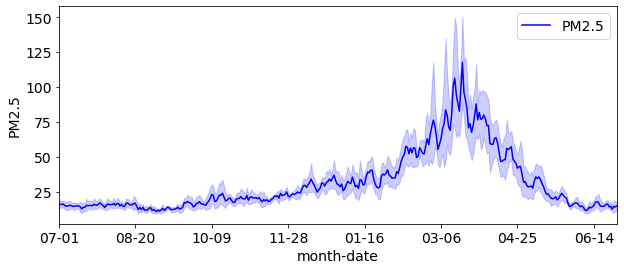

In [194]:
_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(data.data, 'PM2.5', ax, plot_error=True, roll=False, agg='mean')

# Inference

In [384]:
# load model 
data, model, fire_cols, feat_imp = load_model1(city='Chiang Mai', pollutant='PM2.5', split_list=[0.7, 0.3])

rolling True
data no fire has shape (77747, 14)
model performance {'test_r2_score': 0.7087790905988873, 'test_mean_squared_error': 227.67283457136557, 'test_mean_absolute_error': 9.23587087862017}


Text(0.5, 1.0, 'error (by pollution season)')

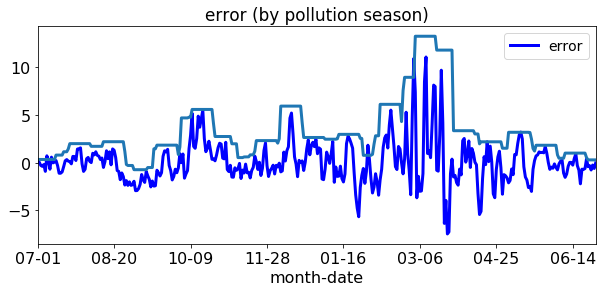

In [5]:
# calculate error of the train dataset
trn_error = cal_error(data, model, data_index=data.split_list[0])
sea_error = cal_season_error(trn_error, roll_win=14, agg='max')


_, ax = plt.subplots(figsize=(10,4))
_ = plot_season_avg(trn_error, 'error', ax, plot_error=False, roll=True, agg='mean')
ax.plot(sea_error['error'],linewidth=3)
ax.set_title('error (by pollution season)')

In [6]:
%%time
# get data sample 
data_samples = get_data_samples(dataset=data, n_samples=100)


Wall time: 16min 52s


# Compare with Actual Data

In [14]:
# predict the data
ypred_df = model.predict(data_samples[data.x_cols].values)
ypred_df = pd.Series(ypred_df, index = data_samples.index)

In [44]:
ypred_df = make_senario(model, data_samples, 'fire_0_100', per_cut= 0, x_cols=data.x_cols)
band_df = make_band(ypred_df, q_list=[0.05, 0.25, 0.5, 0.75,  0.95])

In [45]:
ytest_pred_df = cal_error(data, model, data_index=data.split_list[1])
ytest_pred_df_avg = ytest_pred_df.resample('d').mean().dropna()

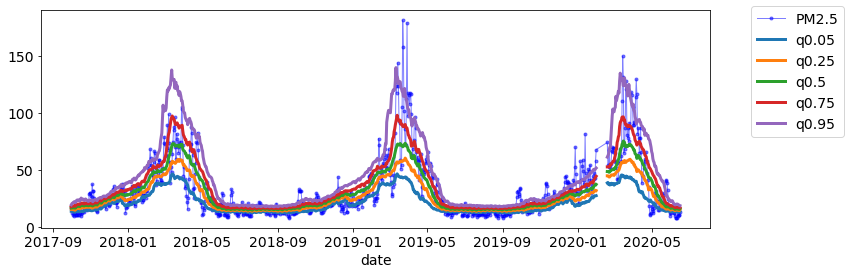

In [46]:
plt.figure(figsize=(12,4))
#ypred_df.plot(alpha=0.3,color='royalblue')
#plt.plot(ytest_pred_df['actual'],color='red',label='data', marker='.', linewidth=0, alpha=0.5)
plt.plot(ytest_pred_df_avg['actual'],color='blue',label='avg data', marker='.', linewidth=1, alpha=0.5)
plt.plot(band_df.resample('d').mean(), linewidth=3)

plt.xlabel('date')
plt.legend(['PM2.5'] + band_df.columns.to_list(), bbox_to_anchor=(1.05, 1.05),frameon=True)


In [47]:
sea_pred = cal_season_band(band_df, sea_error)

In [19]:
transition_dict = { 'PM2.5': [0, 35.5, 55.4, 150.4, 1e3],
            'PM10': [0, 155, 254, 354, 1e3],
            'O3':[0, 70 , 85, 105 ,1e3],
            'SO2':[0, 75, 185, 304,1e3],
            'NO2': [0, 100, 360, 649,1e3],
            'CO': [0, 6.4, 12.5, 15.4,1e3]}
levels = transition_dict[data.monitor][1:4]
colors = ['orange','red', 'purple']

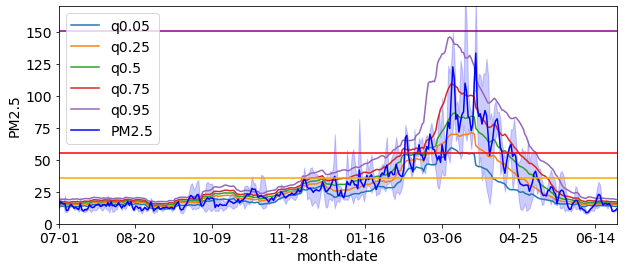

In [48]:
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
_ = plot_season_avg(data.data.loc['2017-10-01':], 'PM2.5', ax, plot_error=True, roll=False, agg='mean')

ax.legend(band_df.columns.to_list() + ['PM2.5'] )
ax.set_ylim([0, 170])

for l, c in zip(levels,colors):
    ax.axhline(l, color=c)

# Senario


In [22]:
features = feat_imp['index'][feat_imp['index'].str.contains('fire')]
print(features)
feat_imp  

0     fire_100_200
1     fire_200_400
2       fire_0_100
4     fire_400_700
5    fire_700_1000
Name: index, dtype: object


,index,importance
0,fire_100_200,0.190716
1,fire_200_400,0.174179
2,fire_0_100,0.162908
3,Humidity(%),0.108128
4,fire_400_700,0.104646
5,fire_700_1000,0.098756
6,Wind Speed(kmph),0.045807
7,Temperature(C),0.035235
8,time_of_day,0.015597
9,wind_S,0.014919


## Fire Zone 0-100

In [68]:
%%time

feature = features[0]
x_cols = data.x_cols
q = 0.95
red_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

sea_pred_all = reduc_effect(model, data_samples, x_cols, feature, sea_error, q=q, red_list= red_list  )

Wall time: 6min 41s


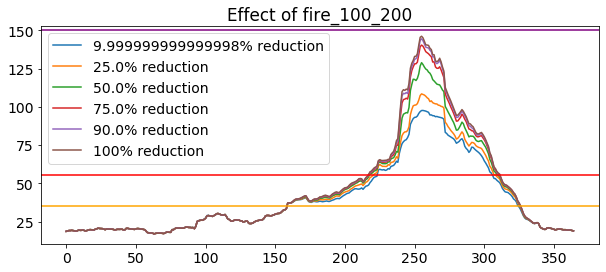

In [61]:
_, ax = plt.subplots(1, 1, figsize=(10, 4))
ax.plot(sea_pred_all) 
ax.legend(sea_pred_all.columns.to_list())
ax.set_title(f'Effect of {feature}')

for l, c in zip(levels,colors):
    ax.axhline(l, color=c)

In [105]:
%%time

x_cols = data.x_cols
q = 0.75
red_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

fea_effect_df = []
for feature in features:
    sea_pred_all = reduc_effect(model, data_samples, x_cols, [feature], sea_error, q=q, red_list= red_list )
    sea_pred_all = sea_pred_all.max(axis=0)
    sea_pred_all.columns = [feature]
    fea_effect_df.append(sea_pred_all)
    
    
fea_effect_df1 = pd.concat(fea_effect_df, axis=1)
fea_effect_df1.columns = features

Wall time: 29min 27s


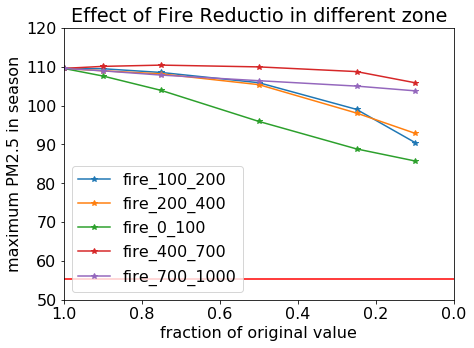

In [106]:
plt.figure(figsize=(7,5))
plt.title("Effect of Fire Reductio in different zone")

plt.plot(fea_effect_df1, marker='*')
plt.legend(fea_effect_df1.columns.to_list())
plt.xlim(1, 0) 
plt.xlabel('fraction of original value')
plt.ylabel('maximum PM2.5 in season')
plt.ylim([50,120])

for l, c in zip(levels,colors):
    plt.axhline(l, color=c)

In [ ]:
%%time

x_cols = data.x_cols
q = 0.7
red_list = [0, 0.1, 0.25, 0.5, 0.75, 0.9]

fea_effect_df = []
for f1, f2 in zip(features, features[1:]):
    feature = [f1, f2]
    sea_pred_all = reduc_effect(model, data_samples, x_cols, feature, sea_error, q=q, red_list= red_list )
    sea_pred_all = sea_pred_all.max(axis=0)
    sea_pred_all.columns = [f1 + f2]
    fea_effect_df.append(sea_pred_all)
    
    
fea_effect_df = pd.concat(fea_effect_df, axis=1)
fea_effect_df.columns = features

In [ ]:
plt.figure(figsize=(7,5))
plt.title("Effect of Fire Reductio in different zone")

plt.plot(fea_effect_df, marker='*')
plt.legend(fea_effect_df.columns.to_list)
plt.xlim(1, 0) 
plt.xlabel('fraction of original value')
plt.ylabel('maximum PM2.5 in season')
plt.ylim([50,160])

for l, c in zip(levels,colors):
    plt.axhline(l, color=c)

# Fire Zone 100 - 400

In [547]:
per = 0.9
data_senario = data_samples_all.copy()
data_senario['fire_100_400'] = data_senario['fire_100_400']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred = tpot_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [548]:
q_list = [0.01, 0.10, 0.5, 0.70,  0.90, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [549]:
band_df.max()

q0.01     34.354505
q0.1      42.656789
q0.5      54.900415
q0.7      74.083100
q0.9      90.831245
q0.99    105.133885
dtype: float64

Text(0.5, 1.0, 'fire_100_400 reduced by 0.9')

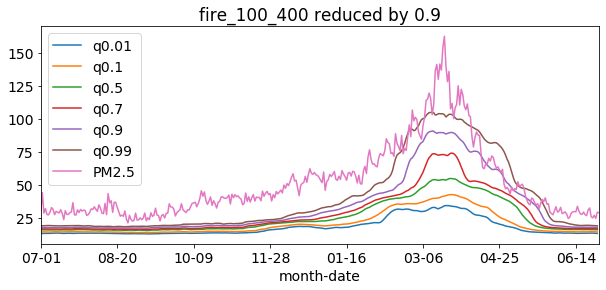

In [550]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_100_400 reduced by {per}')

# Fire fire_700_1000

In [559]:
per = 0.9
data_senario = data_samples_all.copy()
data_senario['fire_700_1000'] = data_senario['fire_700_1000']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred = tpot_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [560]:
q_list = [0.01, 0.10, 0.5, 0.70,  0.90, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [561]:
band_df.max()

q0.01     40.451513
q0.1      50.066480
q0.5      70.457445
q0.7      91.275700
q0.9     116.933441
q0.99    140.003852
dtype: float64

Text(0.5, 1.0, 'fire_700_1000 reduced by 0.9')

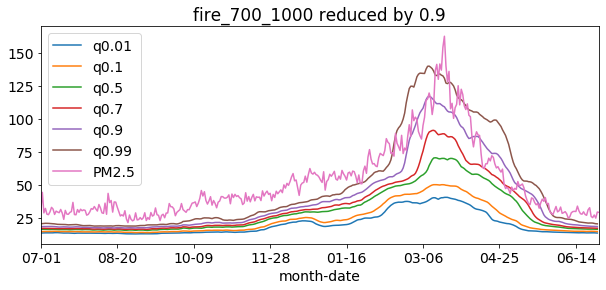

In [562]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_700_1000 reduced by {per}')

# Both fire_0_100, fire_100_400

In [567]:
per = 0.5
data_senario = data_samples_all.copy()
data_senario['fire_0_100'] = data_senario['fire_0_100']*(1-per)
data_senario['fire_100_400'] = data_senario['fire_100_400']*(1-per)
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred = tpot_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples_all.index)

In [568]:
q_list = [0.01, 0.10, 0.5, 0.70,  0.90, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_df.groupby(level=0).quantile(q=q)
    band = smooth(band.values,window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

In [569]:
band_df.max()

q0.01     37.027933
q0.1      46.981947
q0.5      58.720074
q0.7      67.480251
q0.9      85.990016
q0.99    119.659436
dtype: float64

Text(0.5, 1.0, 'fire_0_700 reduced by 0.5')

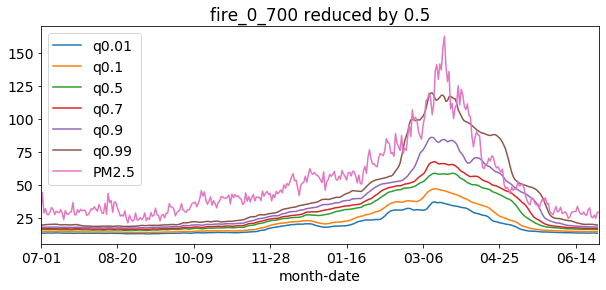

In [571]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=False)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'fire_0_700 reduced by {per}')

# Redo prediction

In [372]:
trn_data = data.data.loc[trn_index]
test_data = data.data.loc[test_index]

wea_cols = ['Temperature(C)', 'Humidity(%)', 'Wind Speed(kmph)', 'wind_CALM', 'wind_E', 'wind_N', 'wind_S', 'wind_W',
       'is_rain']

fire_cols = ['fire_0_100', 'fire_100_400', 'fire_400_700', 'fire_700_1000','PM2.5_lag_1']
# datetime information cols use the data from the test set 
date_cols = ['is_holiday', 'is_weekend', 'day_of_week', 'time_of_day']

wea = trn_data[wea_cols]
fire = trn_data[fire_cols]

In [373]:
n_samples = 100

year_list = trn_data.index.year.unique()
year_sam = np.arange(len(year_list)) + 1
year_sam = year_sam.cumsum()/year_sam.cumsum().sum()
year_sam = (year_sam*n_samples).astype(int)
year_sam

array([ 1,  3,  7, 11, 17, 25, 33])

In [374]:
# add datetimes columns for weather and fire data for the training data 
wea['year'] = wea.index.year
wea['day_of_year'] = wea.index.dayofyear
wea['hour'] = wea.index.hour

fire['year'] = fire.index.year
fire['day_of_year'] = fire.index.dayofyear
fire['hour'] = fire.index.hour

In [357]:
time_range = pd.date_range(start=test_data.index.min(), end=test_data.index.max(), freq='h')

In [376]:
time_range[0]
data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
 # add calenda information 
data_samples = data_samples.set_index('datetime')
data_samples = add_calendar_info(data_samples)

data_senario = data_samples.copy()
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples.index)
ypred_df

datetime
2020-06-15 05:00:00     9.669351
2020-06-15 05:00:00     8.103136
2020-06-15 05:00:00    39.879509
2020-06-15 05:00:00    18.205744
2020-06-15 05:00:00     8.253032
                         ...    
2020-06-15 05:00:00    12.869852
2020-06-15 05:00:00    19.454590
2020-06-15 05:00:00     8.367445
2020-06-15 05:00:00     8.579019
2020-06-15 05:00:00    21.763022
Length: 97, dtype: float64

In [380]:
time_range[1]
data_samples = get_sample(time_range[1], wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
# add calenda information 
data_samples = data_samples.set_index('datetime')
data_samples = add_calendar_info(data_samples)

data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)

data_senario = data_samples.copy()
x = data_senario[x_cols].values
ypred = rf_model.predict(x)
ypred_df = pd.Series(ypred , index=data_samples.index)

In [408]:
%%time
ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples)

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)        


4744it [14:15,  5.55it/s]


Wall time: 14min 15s


In [424]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    54.300340
q0.25    60.548868
q0.5     65.059691
q0.75    70.940758
q0.99    82.378062
dtype: float64


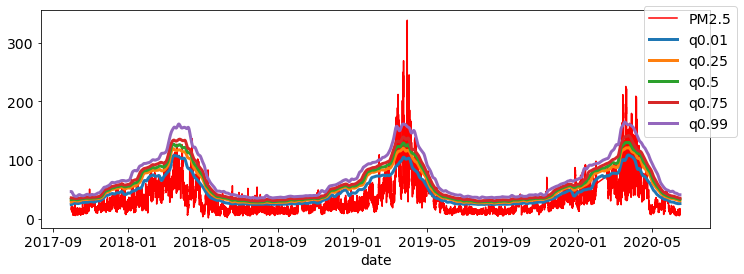

In [425]:
plt.figure(figsize=(12,4))
#ypred_df.plot(alpha=0.3,color='royalblue')

plt.plot(test_index, ytest,color='red',label='data')
plt.plot(band_df*2, linewidth=3)


plt.xlabel('date')
plt.legend(['PM2.5'] + band_df.columns.to_list() , bbox_to_anchor=(1.05, 1.05),frameon=True)

Text(0.5, 1.0, 'normal behavior')

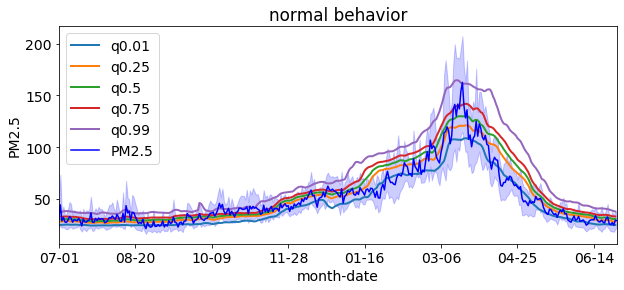

In [428]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(f'normal behavior')

In [439]:
col = 'fire_0_100'
per = 0.7

ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples) 

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    data_senario[col] = data_senario[col]*per
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)    

4744it [14:13,  5.56it/s]


In [440]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    53.699700
q0.25    59.748754
q0.5     64.831086
q0.75    70.318734
q0.99    80.274553
dtype: float64


Text(0.5, 1.0, 'fire_0_100 reduced to 0.7')

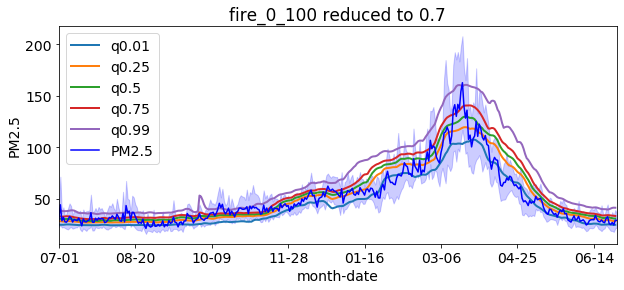

In [441]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(col + f' reduced to {per}')

In [442]:
col = 'fire_100_400'
per = 0.50

ypred_all_list = []
for i, test_datetime in tqdm(enumerate(time_range[::5])):
    data_samples = get_sample(test_datetime, wea, fire,year_list, year_samples=year_sam,day_err=10,hour_err=2)
    # add calenda information 
    data_samples = data_samples.set_index('datetime')
    data_samples = add_calendar_info(data_samples)

    if i > 0:
        data_samples['PM2.5_lag_1'] = np.random.choice(ypred,size=len(data_samples), replace=True)
    
    data_senario = data_samples.copy()
    data_senario[col] = data_senario[col]*per
    x = data_senario[x_cols].values
    ypred = rf_model.predict(x)
    ypred_df = pd.DataFrame(ypred , index=data_samples.index)
    ypred_all_list.append(ypred_df)

ypred_all = pd.concat(ypred_all_list,ignore_index=False)    

4744it [29:33,  2.67it/s]


In [443]:
q_list = [ 0.01, 0.25, 0.5, 0.75, 0.99]

band_df = []
for q in q_list:
    
    band = ypred_all.groupby(level=0).quantile(q=q)
    band_index = band.index
    band = smooth(band.values.reshape(-1),window_len=41)
    
    band_df.append(pd.DataFrame(band, index=band_index, columns=['q'+ str(q)]))
    
band_df = pd.concat(band_df, axis=1)
print(band_df.max())

sea_pred = band_df.resample('d').max().copy()
sea_pred['dayofyear'] = sea_pred.index.dayofyear
sea_pred['year'] = sea_pred.index.year

# add winter day by substratcing the first day of july
winterday = sea_pred['dayofyear'] - 182
# get rid of the negative number
winter_day_max = winterday.max()
winterday[winterday < 0] = winterday[winterday < 0] + 182 + winter_day_max  
sea_pred['winter_day'] = winterday

sea_pred = sea_pred.groupby('winter_day').max()
sea_pred = sea_pred.drop(['dayofyear','year'],axis=1)

q0.01    50.663191
q0.25    56.732371
q0.5     60.230633
q0.75    64.129567
q0.99    75.328384
dtype: float64


Text(0.5, 1.0, 'fire_100_400 reduced to 0.5')

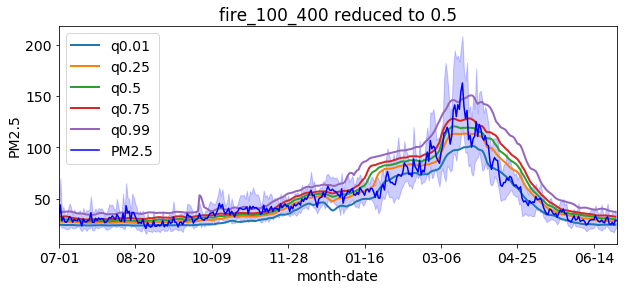

In [444]:
# traffic and time of day
_, ax = plt.subplots(1,1, figsize=(10,4),sharex=True)
ax.plot(sea_pred*2,linewidth=2)
winter_day_dict = plot_season_avg(data.poll_df, 'PM2.5', ax, plot_error=True)

ax.legend(band_df.columns.to_list() + ['PM2.5'])
plt.title(col + f' reduced to {per}')